# Avaliando GANs

Este tutorial fornecerá uma introdução a implementação e avaliação de GANs. Criaremos o modelo usando pytorch com o objetivo de gerar imagens de celebridades utilizando o dataset CelebA.  

O tutorial a seguir foi baseado em [DCGAN TUTORIAL](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) criado por [Nathan Inkawhich](https://github.com/inkawhich)

## Referências importantes:

* Ian J. Goodfellow, et al. - [Generative Adversarial Nets](https://papers.nips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)
* [**GANHACKS:** How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS (DCGAN)](https://arxiv.org/pdf/1511.06434.pdf)

In [1]:
import os
import time
import csv
import pandas
from __future__ import print_function
#%matplotlib inline
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Parâmetros

In [2]:
# Root directory for dataset
dataroot = "/data/CelebA/dcgan/"
# dataroot = "/content/drive/My Drive/datasets/celeba"

output_folder = '/data/CelebA/dcgan/output/'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 512

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# grid size for output images 
nrow = 16

# this value must be >= 'batch_size'
num_samples_output = 512

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Usaremos o conjunto de dados `Celeb-A Faces` que pode ser baixado [aqui](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg). O dataset será baixado como um arquivo chamado `img_align_celeba.zip`. Após o download, crie um diretório chamado `img_celeba` e extraia o arquivo zip para esse diretório. Em seguida, defina a entrada do `dataroot` para este caminho. 

Usaremos a classe de dados `ImageFolder`, que **requer que haja subdiretórios na pasta raiz do conjunto de dados**. 

Criaremos o dataset, dataloader, configurações para execução e visualizaremos alguns dos dados de treinamento.

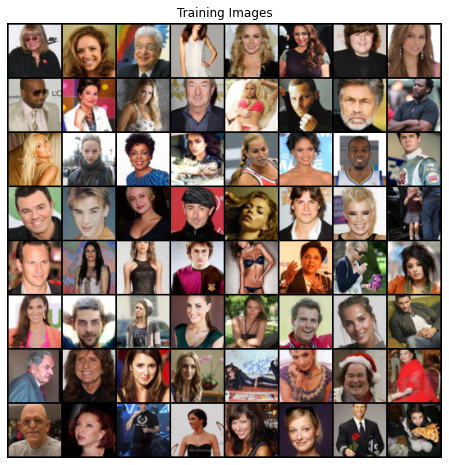

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Implementação

A partir do artigo [DCGAN](https://arxiv.org/pdf/1511.06434.pdf), os autores especificam que todos os pesos do modelo devem ser inicializados aleatoriamente a partir de uma distribuição normal com média = 0, stdev = 0,02. A função `weight_init` inicia e os valores das camadas para atender aos critérios anteriormente citados. 

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Gerador (G)
O gerador `G` é projetado para mapear o vetor de espaço latente `z` para o espaço de dados. Como nossos dados são imagens, converter `z` significa criar uma imagem RGB com o mesmo tamanho das imagens de treinamento (3x64x64). Na prática, isso é realizado por meio de uma série de camadas convolucionais, cada uma delas emparelhada com uma camada batch norm 2d e ativação relu. A saída do gerador `G` é alimentada por uma função `tanh` para retorná-la ao intervalo de dados de entrada de `[-1,1]`. Uma imagem do gerador do papel DCGAN é mostrada abaixo.

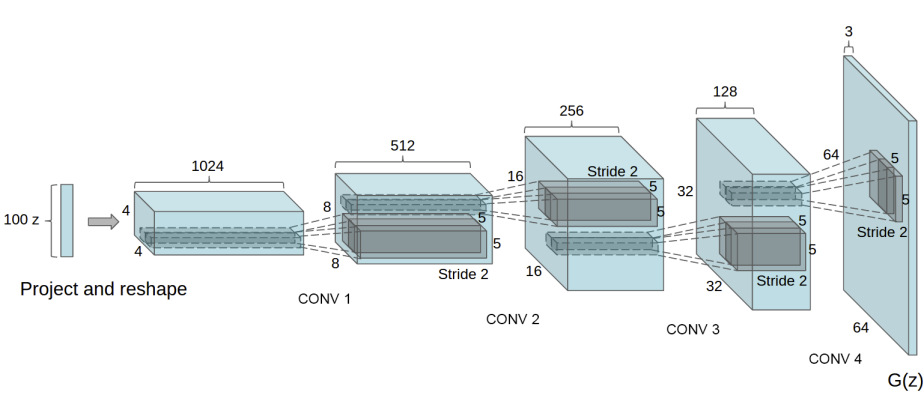

Observe que a forma como as entradas definidas na seção de entrada (`nz`, `ngf` e `nc`) influenciam a arquitetura do gerador no código. `nz` é o tamanho do vetor de entrada `z`, `ngf` é tamanho dos feature maps que são propagados através do gerador. `nc` é o número de canais da imagem de saída (definido como 3 para imagens RGB). Abaixo o código do gerador:

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Agora, podemos instanciar o gerador e aplicar a função `weight_init`. 

In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminador
O discriminador `D` é uma rede de classificação binária que recebe uma imagem como entrada e retorna a probabilidade de que a imagem de entrada seja real (em oposição a fake). 
`D` recebe uma imagem de entrada de 3x64x64, e a processa por meio de uma série de camadas `Conv2d`, `BatchNorm2d` e `LeakyReLU`, gerando a probabilidade final por meio de uma função de ativação sigmóide. Essa arquitetura pode ser estendida com mais camadas caso seja necessário para o problema. 

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Funções Loss e Otimizadores

Com a configuração `D` e `G`, podemos especificar como eles aprendem por meio das funções de perda (loss) e otimizadores. Usaremos a função Binary Cross Entropy (BCELoss) que é definida no PyTorch como:

$$
\ell(x, y)=L=\left\{l_{1}, \ldots, l_{N}\right\}^{\top}, \quad l_{n}=-\left[y_{n} \cdot \log x_{n}+\left(1-y_{n}\right) \cdot \log \left(1-x_{n}\right)\right]
$$

Observe como essa função calcula ambos os componentes do log na função objetivo (ou seja, `log (D (x)) e log (1 − D (G (z)))`). Podemos especificar que parte da equação BCE usar com a entrada `y`. Isso é realizado no loop de treinamento. 

A seguir, definimos nosso rótulo real como 1 e o rótulo fake como 0. Esses rótulos serão usados para calcular a loss de `D` e `G`. Finalmente, **configuramos dois otimizadores separados**, um para `D` e outro para `G`. Conforme especificado no artigo DCGAN, ambos são otimizadores Adam com taxa de aprendizagem (learning rate) de `0,0002` e `Beta1 = 0,5`. Para acompanhar a evolução do aprendizado do gerador, geraremos um batch fixo de vetores latentes modelados por uma distribuição gaussiana (`fixed_noise`). No loop de treinamento, iremos inserir periodicamente este `fixed_noise` em `G` e, ao longo das iterações, veremos imagens a partir do ruído.


In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(num_samples_output, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Treinamento

Com todas as partes do framework GAN definidas, podemos iniciar o treinamento. Seguiremos o Algoritmo 1 do artigo do Goodfellow, juntamente com algumas das práticas mostradas em [ganhacks](https://github.com/soumith/ganhacks). Construiremos diferentes mini-batches para imagens (reais e fake) e ajustaremos a função objetivo de `G` para maximizar o `logD (G (z))`. O treinamento será dividido em duas partes principais. A Parte 1 atualiza o Discriminador e a Parte 2 atualiza o Gerador.

### Parte 1 - Treinando o Discriminador (D)

**O objetivo de treinar o discriminador é maximizar a probabilidade de classificar corretamente uma determinada entrada como real ou fake.** De acordo com Goodfellow, desejamos “atualizar o discriminador ascendendo seu gradiente estocástico”. Na prática, queremos maximizar `log (D (x)) + log (1 − D (G (z)))`. Seguindo a sugestão de ganhacks em separar as imagens em mini-batches, faremos o cálculo em dois passos:

* Construiremos um batch de amostras reais do conjunto de treinamento e propagaremos por `D` (foward propagation). Na sequencia calcularemos o loss (log (D (x))) e calcularemos os gradientes propagando para trás (back-propagation). 
* Construiremos um batch de amostras fake com o gerador (`G`), e propagaremos por `D` (foward propagation). Na sequencia calcularemos o loss (log (1-D (G (z))))) e calcularemos os gradientes propagando para trás (back-propagation). Agora, com os gradientes calculados e acumulados dos batches totalmente reais e totalmente fakes, passaremos para a etapa do **otimizador do Discriminador**.

### Parte 2 - Treinando o Gerador (G)

Queremos treinar o Gerador minimizando `log(1 − D (G (z)))` Para gerar imagens fakes melhores. Conforme visto no paper do Goodfellow, Esse processo não fornece gradientes suficientes, especialmente no início do processo de aprendizagem. Como solução, devemos maximizar `log (D (G (z)))`. 

No código, fazemos isso: 

* classificando a saída do Gerador da Parte 1 com o Discriminador
* computando a loss de `G` usando rótulos reais como `GT`
* computando os gradientes na etapa de backpropagation
* atualizando os parâmetros de `G` com o etapa do otimizador. 


Finalmente, faremos alguns relatórios estatísticos e no final de cada época, enviaremos nosso lote `fixed_noise` através do gerador para rastrear visualmente o progresso do treinamento de G. As estatísticas de treinamento relatadas são:

* `Loss_D` - loss do discriminador calculada como o somatório da loss de todos os batches reais e fakes `(log (D (x)) + log (D (G (z))))`.
* `Loss_G` - loss do gerador (`G`) calculada como `log (D (G (z)))`
* `D (x)` - A média da saída do discriminador (`D`) para todos os batches reais. Isso deve começar perto de 1 e, teoricamente, convergir para 0,5 quando `G` ficar melhor. **Por que deve ocorrer desta maneira?**.
* `D (G (z))` - A média da saída do discriminador (D) para todo os batches fake. O primeiro valor é computado antes de `D` ser atualizado e o segundo valor é calculado depois de `D` ser atualizado. Esses valores devem iniciar perto de 0 e convergir para 0,5, conforme `G` fica melhor. **Por que deve ocorrer desta maneira?**

**Nota:** Esta etapa pode demorar um pouco, dependendo de quantas épocas você executa e do tamanho do conjunto de dados de entrada. Recomenda-se a utilização de GPU.

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
epoch_time=[]
nsamples = 10

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # timer for entire epoch
    # For each batch in the dataloader
    # for i, data in enumerate(dataloader, 0):
    for i, data in enumerate(dataloader, 0):
        #print("i: ",i)
        #if i > nsamples:
            #break
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
   
        real_folder = output_folder + 'real/'
        if iters == 0:    
            if not os.path.exists(real_folder):
                os.makedirs(real_folder)
            #print('type real: ',type(real_cpu))
            #print('shape real: ',real_cpu.shape)

            for j in range(num_samples_output):
                vutils.save_image(real_cpu[j], real_folder + str(j) + '.png')
        
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % nsamples == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
    
            img_list.append(vutils.make_grid(fake, nrow=nrow, padding=2, normalize=True))
            
            grid_folder = output_folder + '/grid/'
    
            if not os.path.exists(grid_folder):
                os.makedirs(grid_folder)
            
            # saving grid image
            vutils.save_image(img_list[-1].to(device)[0], 
                              grid_folder + str(epoch) + '_grid.png',normalize=True)
            
            epoch_folder = output_folder + '/' + str(epoch) + '_epoch' + '/'
            
            if not os.path.exists(epoch_folder):
                os.makedirs(epoch_folder)
            
            # saving generated images to evaluate
            for j in range(num_samples_output):
                vutils.save_image(fake[j], epoch_folder + str(epoch) + '_' + str(j) + '.png')
            
        iters += 1

    curr_epoch_time_taken = time.time() - epoch_start_time
    
    print('Time Taken: %d sec' % curr_epoch_time_taken)
    
    epoch_time.append(curr_epoch_time_taken)


time_folder = output_folder + "time/"

if not os.path.exists(time_folder):
    os.makedirs(time_folder)
    
import pandas
df = pandas.DataFrame(data={str(num_epochs) + '_epochs': epoch_time})
df.to_csv(time_folder + str(num_epochs) + '.csv', sep=',',index=False)

Starting Training Loop...
[0/10][0/396]	Loss_D: 1.6604	Loss_G: 5.2781	D(x): 0.5185	D(G(z)): 0.5295 / 0.0091
[0/10][50/396]	Loss_D: 0.8458	Loss_G: 14.4771	D(x): 0.9614	D(G(z)): 0.5066 / 0.0000
[0/10][100/396]	Loss_D: 0.8515	Loss_G: 5.3182	D(x): 0.9602	D(G(z)): 0.5020 / 0.0081
[0/10][150/396]	Loss_D: 0.6033	Loss_G: 6.4044	D(x): 0.8766	D(G(z)): 0.3202 / 0.0029
[0/10][200/396]	Loss_D: 0.5666	Loss_G: 5.5903	D(x): 0.8662	D(G(z)): 0.2807 / 0.0055
[0/10][250/396]	Loss_D: 0.6497	Loss_G: 3.8846	D(x): 0.8304	D(G(z)): 0.3131 / 0.0363
[0/10][300/396]	Loss_D: 0.4135	Loss_G: 4.9738	D(x): 0.8815	D(G(z)): 0.2015 / 0.0135
[0/10][350/396]	Loss_D: 0.8452	Loss_G: 2.3458	D(x): 0.5269	D(G(z)): 0.0249 / 0.1618
Time Taken: 806 sec
[1/10][0/396]	Loss_D: 0.5560	Loss_G: 4.3942	D(x): 0.8229	D(G(z)): 0.2615 / 0.0195
[1/10][50/396]	Loss_D: 0.7507	Loss_G: 2.6915	D(x): 0.7367	D(G(z)): 0.2925 / 0.0992
[1/10][100/396]	Loss_D: 0.3488	Loss_G: 4.4436	D(x): 0.7906	D(G(z)): 0.0587 / 0.0208
[1/10][150/396]	Loss_D: 0.8206	Loss

## Resultados
A seguir, três resultados diferentes:

* Gráfico da loss de `D` e `G` mudaram durante o treinamento. 
* Saída de `G` no batch `fixed_noise` para cada época. 
* Batch de dados reais ao lado de um batch fake gerado por `G`.

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Exercícios

### Proposta 1
Ao definir o caminho no parâmetro `output_folder`, ao final desse tutorial, a seguinte estrutura de diretórios será criada:

* `0_epoch`: Diretório que contém `num_samples_output` imagens geradas por `G` durante a 1a época
* `1_epoch`: Diretório que contém `num_samples_output` imagens geradas por `G` durante a 2a época
* `2_epoch`: Diretório que contém `num_samples_output` imagens geradas por `G` durante a 3a época
* ...
* `N_epoch`: Diretório que contém `num_samples_output` imagens geradas por `G` durante a `N`-ésima época, onde `N` = `num_epochs` - 1


* `grid`: Diretório que contém um grid de imagens de cada época, cada uma formada por `num_samples_output` imagens
* `real`:  Diretório que contém `num_samples_output` imagens reais
* `time`: Diretório que contém um arquivo `.csv` com os tempos de execução de cada época. Pode ser utilizado para alguma avaliação de tempo.

Avalie a qualidade das imagens geradas pelo seu modelo usando as métricas FID e IS. Construa um gráfico para avaliar época a época. Para isso compare: 

* `0_epoch` vs. `real` = valor referente a avaliação da 1a época
* `1_epoch` vs. `real` = valor referente a avaliação da 2a época
* `2_epoch` vs. `real` = valor referente a avaliação da 3a época
* ...
* `N_epoch` vs. `real` = valor referente a avaliação da `N`-ésima época

Exemplo da representação da distância FID ao longo das épocas:
![](https://lh6.googleusercontent.com/fYyUi5OA94rfY7_ameF8e0Lvfiqp-2MNbrpVqexkoLMqFkp30h9bNz1DirEr4bouVAEDHTD03F3-9NjxRtj3UkyvX5g1Fkzh3rZeB4xgCYwuZ-OoQq4wvOyOiDGkZUHSugwTxpBNNNc)

### Referências:

* Para obter a Fréchet Inception Distance (FID) é possível usar a ferramenta [pytorch-fid](https://github.com/mseitzer/pytorch-fid)
* Para implementar a métrica Inception Score (IS), [visite](https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/) ou utilize a ferramenta [inception-score-pytorch](https://github.com/sbarratt/inception-score-pytorch) 


### Proposta 2
Aumente a quantidade de épocas (parâmetro `N_epoch`) durante o treinamento e avalie se isso impactou positivamente no modelo. Em qual momento a loss de `G` e `D` estabilizaram? 


### Proposta 3
Rode o modelo usando alguma outra base de dados e avalie os resultados.

### Proposta 4
Leia o paper [Pros and Cons of GAN Evaluation Measures](https://arxiv.org/pdf/1802.03446.pdf). Esse trabalho avalia 24 medidas quantitativas e 5 qualitativas ulizadas para avaliar GANs. 